# Time series predictions: PyTorch implementation

References and futher readings:
1. [LSTMs for Time Series in PyTorch](https://www.jessicayung.com/lstms-for-time-series-in-pytorch/) by Jessica Yung
2. [Time Series Prediction using LSTM with PyTorch in Python](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/) by Usman Malik

## Libraries import

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import colorlover as cl
init_notebook_mode(connected=True)

## Data preparation

In [4]:
sales = pd.read_csv('/Users/artyom.makarov/Documents/Computer Vision Nanodegree/Advanced Vision Models/RNN-LSTM/data/sales_full.csv',
                   sep =';')
sales = sales.iloc[:, :5]
data = sales.groupby('date')['sales'].sum().reset_index()

Converting `date` to datetime and `sales` to string. 

In [5]:
data['sales'] = data['sales'].astype('str')
data['sales']=pd.to_numeric(data['sales'])
data['date'] = data['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
data = data.sort_values('date')

In [9]:
# print first 10 rows
data.head(10)

,date,sales
0,2011-01-31,29836
1,2011-02-28,29415
2,2011-03-31,47576
3,2011-04-30,37701
4,2011-05-31,41465
5,2011-06-30,44753
6,2011-07-31,34204
7,2011-08-31,26937
8,2011-09-30,41978
9,2011-10-31,35489


In [10]:
""" 
- group entire sales by date column
- use .rolling() function to estimate mean 
- add resulted column to dataframe 
"""
data_moving=data.groupby('date')['sales'].sum().to_frame()

data_moving['3_moving_av']= data_moving['sales'].rolling(window=3, min_periods=0).mean()

trace_1 = go.Scatter(
   x=data_moving.index,
   y=data_moving['sales'],
   name = "sales amount",
   line = dict(color = '#dd870f'),
   opacity = 1)

trace_2 = go.Scatter(
   x=data_moving.index,
   y=data_moving['3_moving_av'],
   name = "moving-average",
   line = dict(color = '#7F7F7F'),
   opacity = 1)

data_traces = [trace_1,trace_2]

layout = dict(
   title='Moving average for sales amount', template = 'none')

fig = dict(data=data_traces, layout = layout)
iplot(fig)

### Data preparation for modelling

**Step 1**: the sequence preparation

In [11]:
data_full = [float(target) for target in data['sales']]
data_full[:5]

[29836.0, 29415.0, 47576.0, 37701.0, 41465.0]

In [13]:
# set validation data to be 15% from whole data
eval_size = int(len(data_full)*0.15)
train_data = data_full[:len(data_full)-eval_size]
eval_data = data_full[len(data_full)-eval_size:]

print('Size of training data:', len(train_data))
print('Size of evaluation data:', len(eval_data))

print('Training data samples:', train_data[:5])
print('Evaluation data samples:', eval_data[:5])

Size of training data: 82
Size of evaluation data: 14
Training data samples: [29836.0, 29415.0, 47576.0, 37701.0, 41465.0]
Evaluation data samples: [51738.0, 58526.0, 43439.0, 40929.0, 63038.0]


**Step 2**: Scaling data to be from `-1` to `1`

In [14]:
def data_scaling(dataset):
    # define scaler for data to be in range [-1,1]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_norm = scaler.fit_transform(np.array(dataset).reshape(-1, 1))
    data_norm_tensor = torch.Tensor(data_norm).view(-1)
    return data_norm_tensor

In [15]:
train_data_norm = data_scaling(train_data)
eval_data_norm = data_scaling(eval_data)

In [16]:
print('Normalized train data shape:', len(train_data_norm))
print('Normalized train data examples:', train_data_norm[:5])

Normalized train data shape: 82
Normalized train data examples: tensor([-0.7775, -0.8007,  0.1991, -0.3445, -0.1373])


**Step 3:** prepare sequence and targets

The idea is to prepare the sequence of `12` inputs per each. The label (or target) will be the value of `13`- th month. Therefore, we will predict 13th month based on values from last 12 months. <br>
In this case `12` = `T` (or `seq_len`), `batch = 1` and `input_size = 1`.  <br>
Small remark on `input_size`: if case we have some metadata (GDP, material price and etc.), the number of features would be `input_size`. Now, we have one only.<br>
Dealing with text, `input_size` is often `embedding_dim` - the dimension of words' embeddings.

In [17]:
def prepare_sequence(data, seq_len):
    data_seq = []
    for i in range(len(data)-seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len:i+seq_len+1]
        data_seq.append((seq,label))
    return data_seq

In [18]:
train_data_norm_seq = prepare_sequence(train_data_norm, seq_len=12)
eval_data_norm_seq = prepare_sequence(eval_data_norm, seq_len=12)

## Model Building

### Baseline model: 1 layer

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_dim=1, p = 0.0):
        super(LSTM, self).__init__()
        # define the input size, hidden dimension and number of layers
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # define LSTM model 
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, dropout = p)
        # create fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        h0 = torch.zeros(self.num_layers, 1, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_dim)
        return (h0, c0)        
    
    def forward(self, sequence):
        # initialize (h0, c0)
        h0 = torch.zeros(self.num_layers, 1, self.hidden_dim)
        c0 = torch.zeros(self.num_layers, 1, self.hidden_dim)
        # hidden will have shape of (num_layers, batch_size, hidden_dim)
        # output will have a shape of (sequence_length, batch_size, hidden_dim)
        x, hidden = self.lstm(sequence.view(len(sequence), 1, -1), self.hidden)
        # input to linear layer (fully-connected) has a shape of(sequence_length, hidden_dim)
        # output has a shape of (sequence_length, output_dim)
        # note, we will use the output from last timestep (12th)
        x = x[-1].view(1, -1)
        pred = self.fc(x)
        return pred.view(-1)

In [21]:
model_base = LSTM(input_size = 1, hidden_dim = 100, num_layers = 1)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_base.parameters(), lr=0.001)

In [23]:
"""
 - visualize the loss as the model training
"""

def plot_loss(training_losses, validation_losses):
    fig = plt.figure(figsize = (12,6))
    plt.plot(training_losses, label = 'Training loss')
    plt.plot(validation_losses, label = 'Validation loss')
    plt.xlabel('epoch')
    plt.ylabel('Average loss')
    plt.ylim(0, max(validation_losses)) # consistent scale
    
    plt.legend()
    plt.show()

In [24]:
def train(epochs, model, optimizer, criterion, train_data, valid_data): 
    training_losses = []
    validation_losses = []
    
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        valid_loss = 0.0
        # enable training mode
        model.train()
        for seq, label in train_data:
            model.zero_grad()
            model.hidden = model.init_hidden()          
            pred = model(seq)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        # calculate average training loss per epoch
        training_loss /= len(train_data)
        training_losses.append(training_loss)
        
        # enable validation mode 
        model.eval()
        for seq, label in valid_data:
            pred = model(seq)
            loss = criterion(pred, label)
            valid_loss += loss.item()
        # calculate average validation loss per epoch
        valid_loss /= len(valid_data)
        validation_losses.append(valid_loss)
        # print losses
        if epoch % 10 == 0:
            print('Epoch: {}, Training Loss: {:.5f}, Validation Loss: {:.5f}'.format(epoch, training_loss, valid_loss))
    
    plot_loss(training_losses, validation_losses)


Epoch: 10, Training Loss: 0.15455, Validation Loss: 0.17162
Epoch: 20, Training Loss: 0.09456, Validation Loss: 0.11543
Epoch: 30, Training Loss: 0.07397, Validation Loss: 0.01920
Epoch: 40, Training Loss: 0.05422, Validation Loss: 0.00041
Epoch: 50, Training Loss: 0.04141, Validation Loss: 0.00662
Epoch: 60, Training Loss: 0.02717, Validation Loss: 0.03154
Epoch: 70, Training Loss: 0.02103, Validation Loss: 0.01134
Epoch: 80, Training Loss: 0.01557, Validation Loss: 0.04894
Epoch: 90, Training Loss: 0.01619, Validation Loss: 0.02725
Epoch: 100, Training Loss: 0.00890, Validation Loss: 0.04556
Epoch: 110, Training Loss: 0.00654, Validation Loss: 0.03085
Epoch: 120, Training Loss: 0.01677, Validation Loss: 0.07279
Epoch: 130, Training Loss: 0.00602, Validation Loss: 0.07779
Epoch: 140, Training Loss: 0.00995, Validation Loss: 0.03355
Epoch: 150, Training Loss: 0.00609, Validation Loss: 0.06060
Epoch: 160, Training Loss: 0.00304, Validation Loss: 0.03401
Epoch: 170, Training Loss: 0.0048

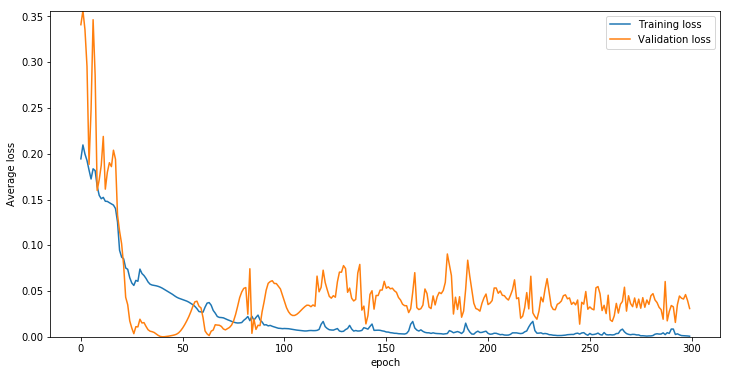

In [25]:
train(300, model_base, optimizer, criterion, train_data_norm_seq, eval_data_norm_seq)

### 2-layers model

Add the second layer of LSTM on top of the first one. Increase the dropout value to have `p=0.1`. 

In [26]:
# a couple of more details on dropout: https://discuss.pytorch.org/t/dropout-for-rnns/633
model_2_layers = LSTM(input_size = 1, hidden_dim = 100, num_layers = 2, p = 0.1)
optimizer_2_layer = torch.optim.Adam(model_2_layers.parameters(), lr=0.001)

Epoch: 10, Training Loss: 0.15290, Validation Loss: 0.14763
Epoch: 20, Training Loss: 0.09830, Validation Loss: 0.02388
Epoch: 30, Training Loss: 0.05396, Validation Loss: 0.00762
Epoch: 40, Training Loss: 0.03888, Validation Loss: 0.00058
Epoch: 50, Training Loss: 0.03720, Validation Loss: 0.02469
Epoch: 60, Training Loss: 0.02085, Validation Loss: 0.02527
Epoch: 70, Training Loss: 0.01308, Validation Loss: 0.02409
Epoch: 80, Training Loss: 0.00994, Validation Loss: 0.02222
Epoch: 90, Training Loss: 0.00765, Validation Loss: 0.02608
Epoch: 100, Training Loss: 0.02135, Validation Loss: 0.02181
Epoch: 110, Training Loss: 0.00501, Validation Loss: 0.02635
Epoch: 120, Training Loss: 0.00463, Validation Loss: 0.01163
Epoch: 130, Training Loss: 0.00467, Validation Loss: 0.01041
Epoch: 140, Training Loss: 0.00454, Validation Loss: 0.00577
Epoch: 150, Training Loss: 0.00967, Validation Loss: 0.01876
Epoch: 160, Training Loss: 0.00328, Validation Loss: 0.01020
Epoch: 170, Training Loss: 0.0236

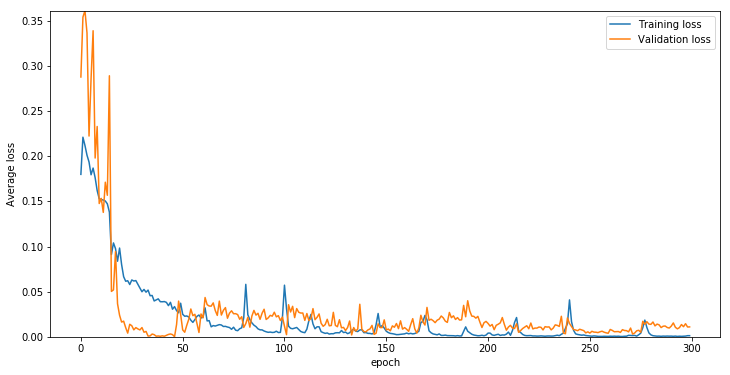

In [27]:
train(300, model_2_layers, optimizer_2_layer, criterion, train_data_norm_seq, eval_data_norm_seq)

**Further research**:

1. As we could observe from graphs above, the *validation loss* tends to oscillate for both 1-layer and 2-layer models. Adding more data and increasing the size of validation dataset can potentially help stabilizing error. 
2. However, adding the second layer to a model with the usage of dropout (`p=1`) partially mitigated the bias between training and validation loss after 50 epochs. Further parameters-tuning can help to increase performance.